# Mini Use Case CNN Klassifizierung.

Hier befindet sich der [Beispielcode](./CNN_added_LRP.ipynb) für das Implementieren eines CNN. Ziel ist es, dass wir Bilder, auf denen eine Ziffer als Zeichensprache abgebildet ist, klassifizieren können. 

Die Software Requirements sind [hier](./requirements.txt) zu finden. Eine Anleitung wie diese Installiert werden können sind in der [ReadMe](./ReadMe.md) zu finden.


![0](./visu/example_0.JPG) 
![1](./visu/example_1.JPG) 
![2](./visu/example_2.JPG) 

## Importieren der Bibliotheken
In der folgenden Zelle werden die notwendigen Bibliotheken eingebunden, welche über die Requirements Datei installiert werden können. Falls Sie dies noch nicht gemacht haben finden sie mehr Informationen dazu in der [ReadMe](./ReadMe.md)

In [1]:
import matplotlib.pyplot as plt                     # Matplotlib zum plotten diverser Visualisierungen 
import matplotlib.image as mpimg                    # 
import numpy as np                                  # Bibliothek zum verarbeiten von Arrays und Matrizen
import os                                           # Bibliothek die hilft unsere Pfade zu verwalten
#import PIL                                          
import tensorflow as tf                             # Tensorflow Bibliothek. Diese verwenden wir für den Aufbau des CNNs
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib                                      # Bibliothek die hilft die Pfade zu verwalten 
import cv2                                          # OpenCV Bibliothek die für die Kamera und Bildverarbeitung eingesetzt wird 
from tf_explain.core.grad_cam import GradCAM        # Bibliothek für die Darstellung des CNNs 

2022-05-13 15:58:11.603624: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/moritz/master_ws/devel/lib:/opt/ros/noetic/lib:/opt/ros/noetic/lib/x86_64-linux-gnu
2022-05-13 15:58:11.603709: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Datenaufbereitung

Die folgenden Zellen beschäftigen sich mit der Datenaufbereitung. Wie schon im Storyboard angesprochen benötigen wir einen Datensatz für unser Modell. Hierzu verlinken wir auf unsere Ordner mit den Bildern des Datensatzes. Anschließend können wir randbedingungne definieren sowie die Aufteilung in Trainings und Test Datensatz durchführen. 
In unserem Fall verwenden wir einen 80/20 Split. Sprich zufällig werden 80% der Bilder aus dem Datensatz herangezogen um die Trainingsdaten abzubilden. Die restlichen 20% werden verwendet um während dem Trainingsprozess das Modell zu testen. 

In [2]:
path_string = "data/"                                           # Pfad zu dem Ordner der Trainingsdaten
image_path = pathlib.Path(path_string) 
data_dir = image_path
image_count = len(list(image_path.glob('*/*.JPG')))             # Hier wird das Bildformat definiert. Andere möglichkeiten können auch .PNG, .jpg, ... sein 
print("Es wurden {} Bilder gefunden." .format(image_count))     # Gibt aus wie viele Bilder gedunden wurden. 


Es wurden 2062 Bilder gefunden.


In [3]:
#Angeben wie groß die Batch und Bildgröße für das CNN-Model sein soll

batch_size = 32     # Gibt an wie viele Bilder pro Trainingsdurchlauf verwendet werden sollen
img_height = 100    # Gibt die Bildhöhe in Pixel an 
img_width = 100     # Gibt die Bildbreite in Pixel an. 

In [4]:
# Datensatz erstellen
# 80/20 Split 

print("**** Tensorflow Output ****")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(     # Ersellt den Trainingssplit (80% des Datensatzes)
  data_dir,
  validation_split=0.2,
  subset="training", 
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(       # Erstellt den Validation Split
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


**** Tensorflo Output ****
Found 2062 files belonging to 10 classes.
Using 1650 files for training.
Found 2062 files belonging to 10 classes.
Using 412 files for validation.


2022-05-13 15:58:14.706247: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-13 15:58:14.706612: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/moritz/.local/lib/python3.8/site-packages/cv2/../../lib64:/home/moritz/master_ws/devel/lib:/opt/ros/noetic/lib:/opt/ros/noetic/lib/x86_64-linux-gnu
2022-05-13 15:58:14.706700: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/moritz/.local/lib/python3.8/site-packages/cv2/../../lib64:/home/moritz/master_ws/devel/lib:/opt/ros/noetic/lib:/opt/ros/noetic/l

In [5]:
# Diese Zelle fasst den erstellten Datensatz zusammen
# für den Use-Case benötigen wir 10 Klassen (1 Klasse pro Zahl)
# Sollte das nicht angezeigt werden, kann es sein, dass die Trainingsbilder nicht richtig gefunden wurden und die Ordnerstruktur kann überprüft werden 
print("\n**** Datensatz Zusammenfassung ****")
class_names = train_ds.class_names
num_classes = len(class_names)
print("Es werden {} Klassen verwendet." .format(num_classes))
print("Folgende Klassen Namen wurden gefunden: {}" .format(class_names))


**** Datensatz Zusammenfassung ****
Es werden 10 Klassen verwendet.
Folgende Klassen Namen wurden gefunden: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


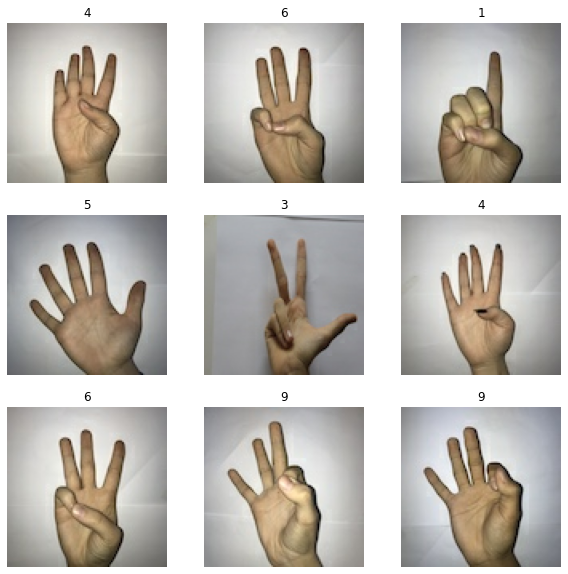

In [6]:
# Ausgabe von Beispielbildern des Datensatzes

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


## Augmentierung 
Die folgenden Zellen beschäftigen sich mit der Augmentierung des Datensatzes. Diese Verfahren ermöglicht es künstlich den Datensatz zu erweitern. Wir verwenden vier Methoden um dies durchzuführen. Spiegeln, Drehen, Zoomen und Kontrast ändern. Diese Methoden werden zufällig für den Trainingsdatensatz angewendet und als neues Trainingsbild gespeichert. So kann künstlich der Datensatz vergrößert werden. Das Hilft uns das CNN besser zu trainieren indem wir hoffentlich nur wichtige Merkmale dadurch extrahieren. 

In [7]:
# Bild augmentation 

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


# Anwenden der verschiedenen Augmentation Styles 
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("vertical", input_shape=(img_height, img_width,3)),    # Bild Flippen (Vertikal / Spiegeln)
    layers.experimental.preprocessing.RandomRotation(0.1),                                              # Bild drehen
    layers.experimental.preprocessing.RandomZoom(0.1),                                                  # Bild hinein Zoomen
    layers.experimental.preprocessing.RandomContrast(0.1),                                              # Kontrast ändern
  ]
)


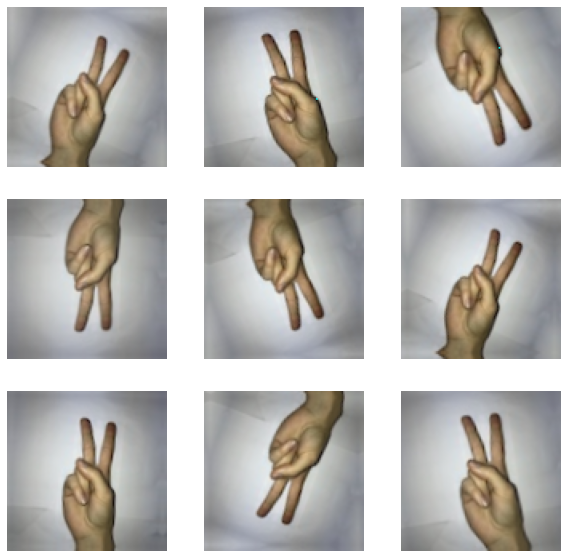

In [8]:
# Anzeigen einiger augmentierter Bilder

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


## Model Definieren

Nachdem wir nun den Datensatz definiert haben, können wir uns um unser Modell kümmern. Wie schon im Storyboard angesprochen werden wir hierzu ein Sequential Modell verwenden welches wir über Tensorflow2 implementieren. Wir verwenden dazu die Anleitung in der Dokumentation von der Tensorflow Bibliothek. Mehr Informationen zu dem Modell und aufbau sind [hier](https://www.tensorflow.org/tutorials/images/classification) zu finden.

In [9]:
num_classes = len(class_names)  # Definiert die Dimension der letzten Layer. 
                                # Muss die Anzahl der Klassen widerspiegeln, damit wir für jede Zahl eine Prediction bekommen können.

model = Sequential([            # Definiert das Modell
  data_augmentation,            # bindet die Bild Augmentierung ein 
  layers.Rescaling(1./255),     # Normiert das Eingangsbild
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)     # Output Layer um eine Predicition zu bekommen 
])

In [10]:
# Hier wird das Model kompiliert und eine Zusammenfassung ausgegeben
# kompilieren 
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Zusammenfassung
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 100, 100, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 100, 100, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 32)       0         
 2D)                                                  

## Trainieren 
In der anschließenden Zelle wird der befehle ausgeführt um das Modell zu trainieren. die wichtigste Variable, welche hier bearbeitet werden kann sind die Epochs. Diese sind zurzeit mit 50 definiert. Diese bestimmt wie viele Trainingszyklen das Modell durchlaufen soll. Mit 50 Zyklen wird eine Genauigkeit von 93.82% erreicht. Diese Zelle ist sehr rechenaufwändig und kann einige Minuten laufen, abhängig von der Anzahl der Epochs sowie der Hardware die Ihnen zur verfügung steht. 

In [11]:
# Trainieren des Models
epochs = 5   # Angabe der Trainingszyklen

history = model.fit(   # Trainingsfunktion
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
)

Epoch 1/5
52/52 [==============================] - 9s 151ms/step - loss: 2.3166 - accuracy: 0.0976 - val_loss: 2.3030 - val_accuracy: 0.1117
Epoch 2/5
52/52 [==============================] - 9s 167ms/step - loss: 2.2864 - accuracy: 0.1345 - val_loss: 2.1925 - val_accuracy: 0.2961
Epoch 3/5
52/52 [==============================] - 9s 176ms/step - loss: 2.0464 - accuracy: 0.2848 - val_loss: 1.7431 - val_accuracy: 0.3714
Epoch 4/5
52/52 [==============================] - 9s 172ms/step - loss: 1.6900 - accuracy: 0.4079 - val_loss: 1.3521 - val_accuracy: 0.5655
Epoch 5/5
52/52 [==============================] - 8s 150ms/step - loss: 1.3557 - accuracy: 0.5333 - val_loss: 1.0151 - val_accuracy: 0.7136


## Ergebnis

Anschließend beschäftigen wir uns mit den Ergebnissen des Trainingszyklus. Die erste Grafik beschäftigt sich mit der Accuracy, sprich der Genauigkeit unseres Modells, sowie der Loss Funktion. Was diese Funktionen genau aussagen wurde bereits im Storyboard besprochen. Schnell zusammengefasst versuchen wir die Genauigkeit möglichst nahe an 100% (bzw. 1.0) anzunähern, während die Loss-Funktion sich gegen 0.0 annähern sollte. 

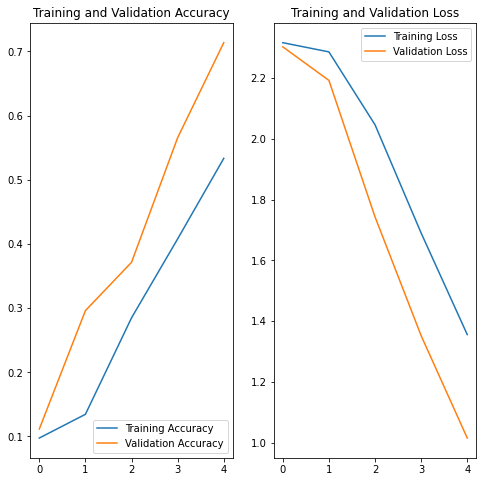

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Model Testen

Sind wir mit dem Trainingsergebnis zufrieden, können wir das Modell nun testen und einsetzen. In der folgenden Zelle werden von jeder Klasse 1 Testbild geladen. Im Terminal (unter der Zelle) wird nun augegeben mit was für einer Sicherheit das Modell denkt, welche Ziffer zu sehen ist.

In [13]:
import cv2
cv2.namedWindow("TEST",0)

i = 0
for filename in os.listdir("demo"):
    img = cv2.imread(os.path.join("demo/",filename))   # Laden des Testbildes

    if img is None:                                     # Fehlerfall behandeln
        print(os.path.join("demo/",filename))
        break
    else:
        image = img                                     # Wenn ein Bild erfolgreich geladen ist kann die prediction stattfinden. 
        np_image_data = np.asarray(image)               # Umformen des Datentyps
        image = np.expand_dims(image, axis=0)           
        predictions = model.predict(image)              # Prediction mittels unseren Trainierten CNNs 
        score = tf.nn.softmax(predictions)              # Auswerten des Ergebnis und anschließend ausgeben. 
        print("Auf dem Bild ist zu {:.2f}% eine {} zu sehen.".format(100 * np.max(score), class_names[np.argmax(score)]))    

        cv2.imshow("TEST", img)                         # Anzeigen des Bildes, welches gerade verwendet wurde für die Prediciton 
        if cv2.waitKey(0) & 0xFF == ord('q'):    
            break


cv2.destroyAllWindows()

Qt: Session management error: Could not open network socket


Auf dem Bild ist zu 57.53% eine 1 zu sehen.


In [14]:
from lrp import * 
import yaml

#for layer in model.layers:
#    print(layer.name)
#print([layer.name for layer in model.layers])



conf = yaml.safe_load(open("config.yml"))
lrp = RelevancePropagation(conf, model)


['dense_1', 'dense', 'flatten', 'dropout_1', 'max_pooling2d_2', 'conv2d_2', 'dropout', 'max_pooling2d_1', 'conv2d_1', 'max_pooling2d', 'conv2d', 'rescaling', 'sequential']


ValueError: Exception encountered when calling layer "tf.linalg.matmul" (type TFOpLambda).

Dimensions must be equal, but are 128 and 3 for '{{node tf.linalg.matmul/MatMul}} = BatchMatMulV2[T=DT_FLOAT, adj_x=false, adj_y=false](Placeholder, tf.linalg.matmul/MatMul/b)' with input shapes: [?,128], [3,3,3,16].

Call arguments received:
  • a=tf.Tensor(shape=(None, 128), dtype=float32)
  • b=tf.Tensor(shape=(3, 3, 3, 16), dtype=float32)
  • transpose_a=False
  • transpose_b=False
  • adjoint_a=False
  • adjoint_b=False
  • a_is_sparse=False
  • b_is_sparse=False
  • output_type=None
  • name=None

## Testzelle zur Visualisierung. 
Ouptut wird in visu gespeichert. 

Layer-wise relevance Propagation -> trying https://tf-explain.readthedocs.io/en/latest/usage.html implementation

In [ ]:

explainer = GradCAM()

i = 0
for filename in os.listdir("demo"):
    img = cv2.imread(os.path.join("demo/",filename))
    #img = resize(img, (width, height))
    if img is None:
        print(os.path.join("demo/",filename))
        break
    else:
        img = tf.keras.preprocessing.image.load_img("demo/"+filename, target_size=(100, 100))
        img = tf.keras.preprocessing.image.img_to_array(img)
        data = ([img], None)
        grid = explainer.explain(data, model, class_index=1)  
        vis = np.concatenate((img, grid), axis=1)
        explainer.save(vis, ".", "visu/"+filename)

# Camera
In der folgenden Zelle wird die Webcam eingebunden. Halten wir nun in die Webcam unsere Hand können wir so versuchen wie das CNN auf die diversen Handzeichen reagiert unter "real-life" Bedingungen. 

In [ ]:

cv2.namedWindow("cam",0)
cap = cv2.VideoCapture(0)  # Öffnen der Webcam
  
while(True):
      
    ret, frame = cap.read() # Einen Frame aus dem Live Kamerafeed abgreifen
    
    # Kamerabild auf ein rechteck mit 100x100 Pixeln eingrenzen. (Bildgröße muss mit trainierten Bildern übereinstimmen)
    cropped_full = frame[40:440, 120:620]
    down_points = (100, 100)
    cropped = cv2.resize(cropped_full, down_points,interpolation= cv2.INTER_LINEAR)

    # Trainiertes CNN auf das Kamerabild anwenden und Ergebnis auf das Kamerabild schreiben. 
    image = np.expand_dims(cropped, axis=0)
    predictions = model.predict(image)
    score = tf.nn.softmax(predictions)
    cv2.putText(cropped_full, str("Auf dem Bild ist zu {:.2f}% eine {} zu sehen.".format(100 * np.max(score), class_names[np.argmax(score)])),
               (20, 30),
                1, 1, (0,0,0), 1)


    # Visualisierung dazu starten
    data = ([cropped], None)
    grid = explainer.explain(data, model, class_index=int(class_names[np.argmax(score)]))
    grid = cv2.resize(grid, (400,400) ,interpolation= cv2.INTER_AREA)
    vis = np.concatenate((cropped_full, grid), axis=1)




    cv2.imshow('cam', vis) # Ergebnis anzeigen. 

    # mit 'q' kann der Kamera Stream beendet werden. 
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    
# nach Abbruch des Kamera Streams wird die Kamera wieder freigegeben und die Fenster gelöscht. 

cap.release()
cv2.destroyAllWindows()